In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))
from IPython.display import display_markdown

In [14]:
from datetime import datetime, timedelta
from PIL import Image
from glob import glob
import numpy as np
import pandas as pd
from math import cos, sin, sqrt, atan
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from os.path import basename, join
from shapely import geometry
import sys
import time
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

In [15]:
in_kaggle = False

if in_kaggle:
    csv_fn = '../input/nfl-big-data-bowl-2021/week1.csv'
else:
    csv_fn = './data/week12.csv'

stop_at = 500 # np.inf run the whole dataframe

In [16]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33),
                          facecolor='None'):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor=facecolor, zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='black')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='black')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='black', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='black')
        ax.plot([x, x], [53.0, 52.5], color='black')
        ax.plot([x, x], [22.91, 23.57], color='black')
        ax.plot([x, x], [29.73, 30.39], color='black')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

In [17]:
receivers = ['WR', 'RB', 'TE', 'FB', 'HB']
defense = ['CB', 'OLB', 'FS', 'LB', 'SS', 'ILB', 'DE', 'DB', 'MLB', 'DT', 'S', 'NT']

rect_width = 2
frame_rate = 1
field_width = 53.3
field_length = 120

def eligible_receivers(row):
    if row['position'] in receivers:
        return True
    return False

def is_defense(row):
    if row['position'] in defense:
        return True
    return False

def tx_x(x, y, theta):
    return x * cos(theta) + y * sin(theta)
    
def tx_y(x, y, theta):
    return y * cos(theta) - x * sin(theta)

def get_polygon(row):
    if not row['frameId'] % frame_rate == 0 or not (row['eligible_receiver'] or row['is_defense']):
        return None
    x = row['x']
    y = row['y']
    s = max(row['s'], rect_width)  * -1
    d = rect_width * -1
    theta = row['dir'] * np.pi / 180 + np.pi / 2

    points = [[x + tx_x(-d, d, theta), y + tx_y(-d, d, theta)],
              [x + tx_x(s, d, theta), y + tx_y(s, d, theta)],
              [x + tx_x(s, -d, theta), y + tx_y(s, -d, theta)],
              [x + tx_x(-d, -d, theta), y + tx_y(-d, -d, theta)]]
    try:
        return geometry.Polygon(points)
    except Exception as e:
        print(row)
        raise e

In [18]:
data = pd.read_csv(csv_fn)
data['eligible_receiver'] = data.apply(lambda row: eligible_receivers(row), axis=1)
data['is_defense'] = data.apply(lambda row: is_defense(row), axis=1)
data['polygon'] = data.apply(lambda row: get_polygon(row), axis=1)
data['openness'] = np.nan
data.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,frameId,team,gameId,playId,playDirection,route,eligible_receiver,is_defense,polygon,openness
0,2018-11-22T17:39:48.599Z,31.99,26.86,0.08,0.07,0.01,97.26,76.57,None,79860.0,...,1,home,2018112200,83,right,NaN,False,False,None,NaN
1,2018-11-22T17:39:48.599Z,37.15,43.19,0.00,0.00,0.00,263.41,357.67,None,2495108.0,...,1,away,2018112200,83,right,NaN,False,True,"POLYGON ((35.23296343755754 41.11034358168018,...",NaN
2,2018-11-22T17:39:48.599Z,39.62,31.97,0.12,0.11,0.02,266.92,299.15,None,2532961.0,...,1,away,2018112200,83,right,NaN,False,True,"POLYGON ((40.39249955488906 29.24910962409431,...",NaN
3,2018-11-22T17:39:48.599Z,31.86,23.66,0.00,0.00,0.00,99.08,102.70,None,2540020.0,...,1,home,2018112200,83,right,FLAT,True,False,"POLYGON ((30.34862332081396 26.05076149659739,...",NaN
4,2018-11-22T17:39:48.599Z,35.58,31.46,0.00,0.00,0.00,100.63,171.63,None,2540203.0,...,1,home,2018112200,83,right,SLANT,True,False,"POLYGON ((37.26756731893602 33.72982742605227,...",NaN


In [19]:
def bounding_box(row, qb_x):
    if row.polygon is None:
        return None
    if row['playDirection'] == 'right':
        x_min = max(0, qb_x)
        x_max = field_length
    else:
        x_min = 0
        x_max = min(qb_x, field_length)
    box = geometry.Polygon([[x_min, 0], [x_min, field_width], [x_max, field_width], [x_max, 0]])
    return box.intersection(row.polygon)

def add_qb_view(row, qb_x, qb_y):
    if row.polygon is None:
        return None
    if not row.eligible_receiver:
        return row.polygon
    try:
        x, y = row.polygon.exterior.coords.xy
        ratio = np.divide(np.subtract(qb_x, x), np.subtract(qb_y, y))
        thetas = np.arctan(ratio)
        min_idx = np.argmin(thetas)
        max_idx = np.argmax(thetas)
        triangle = geometry.Polygon([[qb_x, qb_y],
                                     [x[min_idx], y[min_idx]],
                                     [x[max_idx], y[max_idx]]])
        return geometry.MultiPolygon([triangle, row.polygon]).buffer(0)
    except AttributeError:
        return row.polygon
        
def oppenness(row, def_polygons):
    if row.polygon is None or not row.eligible_receiver:
        return None
    try:
        return (row.polygon.area - row.polygon.intersection(def_polygons).area) / row.polygon.area
    except ZeroDivisionError:
        return 0.

In [20]:
play_groups = data.groupby(['gameId', 'playId', 'frameId'])
print(f'{len(play_groups)}: play_groups')

n = stop_at if stop_at < np.inf else 'all'
print(f'Calculating openness for {n} frames.')

i = 0
for play_frame, g_df in tqdm(play_groups):
    try:
        qb_x, qb_y = g_df.loc[g_df['position'] == 'QB'][['x', 'y']].values[0]
    except IndexError:
        continue
    data.loc[g_df.index, 'polygon'] = data.loc[g_df.index].apply(lambda row: bounding_box(row, qb_x), axis=1)
#     data.loc[g_df.index, 'polygon'] = data.loc[g_df.index].apply(lambda row: add_qb_view(row, qb_x, qb_y), axis=1)
    defense = data.loc[g_df.index].query('is_defense == True')
    def_polygons = geometry.MultiPolygon(defense['polygon'].to_list()).buffer(0)
    data.loc[g_df.index, 'openness'] = data.loc[g_df.index].apply(lambda row: oppenness(row, def_polygons), axis=1)
    i += 1
    if i > stop_at:
        break
if not in_kaggle:
    p_fn = csv_fn.replace('.csv', '.pickle')
else:
    p_fn = basename(csv_fn).replace('.csv', '.pickle')
data.to_pickle(p_fn)
data.tail()

69981: play_groups
Calculating openness for 500 frames.


,time,x,y,s,a,dis,o,dir,event,nflId,...,frameId,team,gameId,playId,playDirection,route,eligible_receiver,is_defense,polygon,openness
1024863,2018-11-27T04:03:17.500Z,30.58,44.67,0.73,0.80,0.07,69.30,66.16,None,2558853.0,...,123,home,2018112600,3833,left,NaN,False,True,"POLYGON ((27.9422766451069 45.69098751366093, ...",NaN
1024864,2018-11-27T04:03:17.500Z,32.22,46.54,2.94,2.81,0.31,344.05,316.92,None,2558942.0,...,123,away,2018112600,3833,left,HITCH,True,False,"POLYGON ((32.12523623533959 43.71316080596943,...",NaN
1024865,2018-11-27T04:03:17.500Z,33.10,47.04,1.63,2.41,0.18,298.43,272.35,None,2560774.0,...,123,home,2018112600,3833,left,NaN,False,True,"POLYGON ((35.01631050862845 44.95967453639577,...",NaN
1024866,2018-11-27T04:03:17.500Z,31.05,29.08,4.22,1.57,0.43,7.70,1.65,None,2561521.0,...,123,away,2018112600,3833,left,GO,True,False,"POLYGON ((28.99324135887599 27.13841716834905,...",NaN
1024867,2018-11-27T04:03:17.500Z,31.30,48.14,0.33,2.40,0.06,NaN,NaN,None,NaN,...,123,football,2018112600,3833,left,NaN,False,False,None,NaN


Saving graph: ./graphs/2018112200/190\PlayAction_1.png
Saving graph: ./graphs/2018112200/190\Openness_1.png
Saving graph: ./graphs/2018112200/190\PlayAction_2.png
Saving graph: ./graphs/2018112200/190\Openness_2.png
Saving graph: ./graphs/2018112200/190\PlayAction_3.png
Saving graph: ./graphs/2018112200/190\Openness_3.png
Saving graph: ./graphs/2018112200/190\PlayAction_4.png
Saving graph: ./graphs/2018112200/190\Openness_4.png
Saving graph: ./graphs/2018112200/190\PlayAction_5.png
Saving graph: ./graphs/2018112200/190\Openness_5.png
Saving graph: ./graphs/2018112200/190\PlayAction_6.png
Saving graph: ./graphs/2018112200/190\Openness_6.png
Saving graph: ./graphs/2018112200/190\PlayAction_7.png
Saving graph: ./graphs/2018112200/190\Openness_7.png
Saving graph: ./graphs/2018112200/190\PlayAction_8.png
Saving graph: ./graphs/2018112200/190\Openness_8.png
Saving graph: ./graphs/2018112200/190\PlayAction_9.png
Saving graph: ./graphs/2018112200/190\Openness_9.png
Saving graph: ./graphs/20181

c:\users\dparis\gt\datavis\gp\venv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


Saving graph: ./graphs/2018112200/190\PlayAction_11.png
Saving graph: ./graphs/2018112200/190\Openness_11.png
Saving graph: ./graphs/2018112200/190\PlayAction_12.png
Saving graph: ./graphs/2018112200/190\Openness_12.png
Saving graph: ./graphs/2018112200/190\PlayAction_13.png
Saving graph: ./graphs/2018112200/190\Openness_13.png
Saving graph: ./graphs/2018112200/190\PlayAction_14.png
Saving graph: ./graphs/2018112200/190\Openness_14.png
Saving graph: ./graphs/2018112200/190\PlayAction_15.png
Saving graph: ./graphs/2018112200/190\Openness_15.png
Saving graph: ./graphs/2018112200/190\PlayAction_16.png
Saving graph: ./graphs/2018112200/190\Openness_16.png
Saving graph: ./graphs/2018112200/190\PlayAction_17.png
Saving graph: ./graphs/2018112200/190\Openness_17.png
Saving graph: ./graphs/2018112200/190\PlayAction_18.png
Saving graph: ./graphs/2018112200/190\Openness_18.png
Saving graph: ./graphs/2018112200/190\PlayAction_19.png
Saving graph: ./graphs/2018112200/190\Openness_19.png
Saving gra

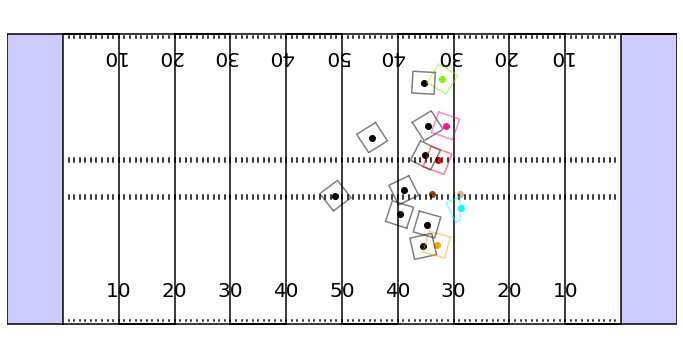

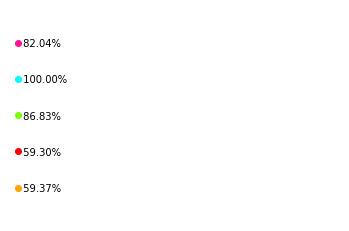

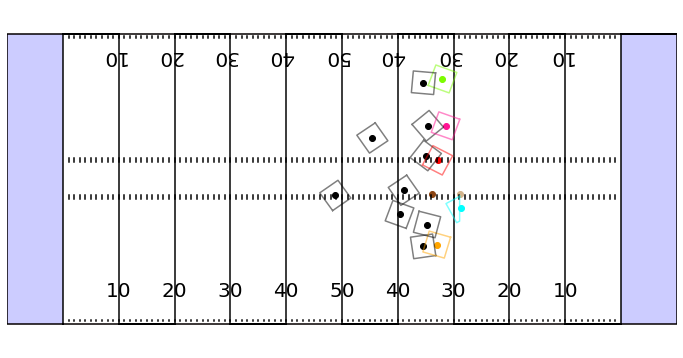

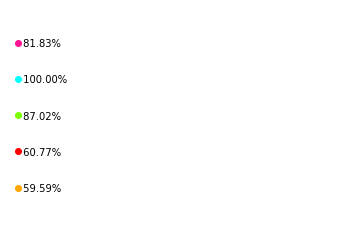

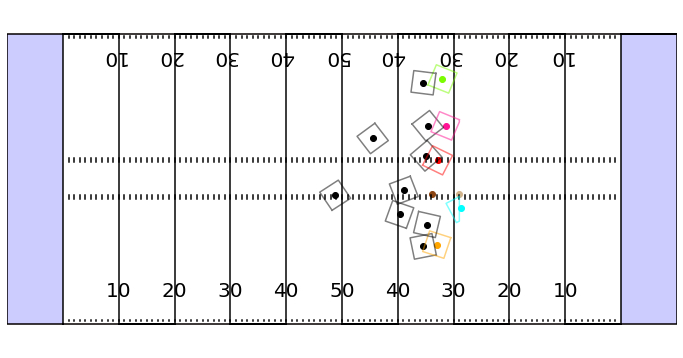

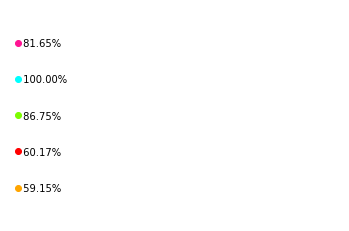

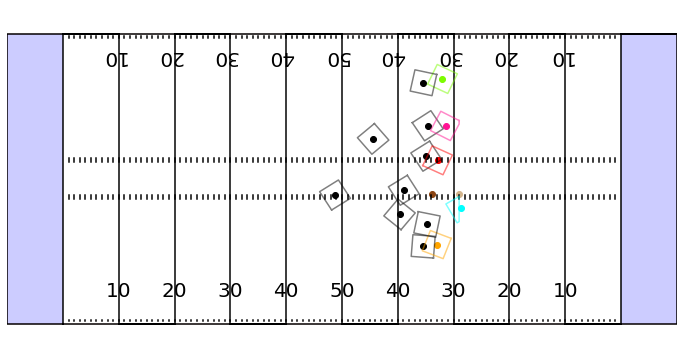

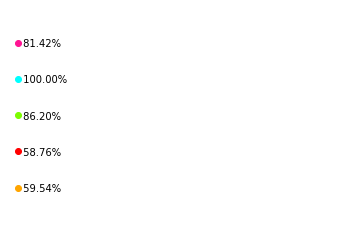

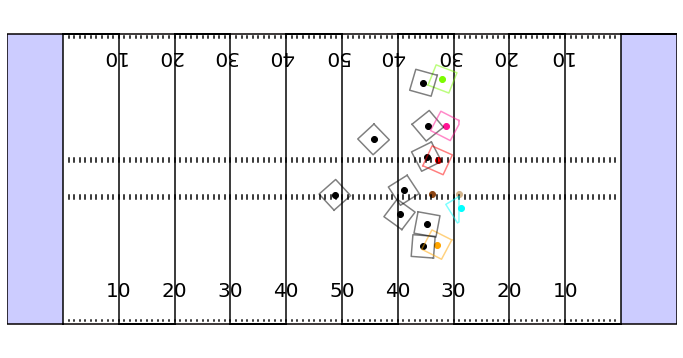

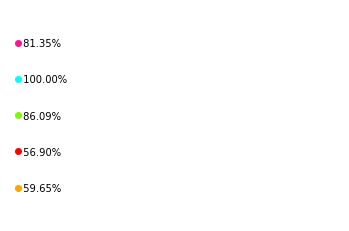

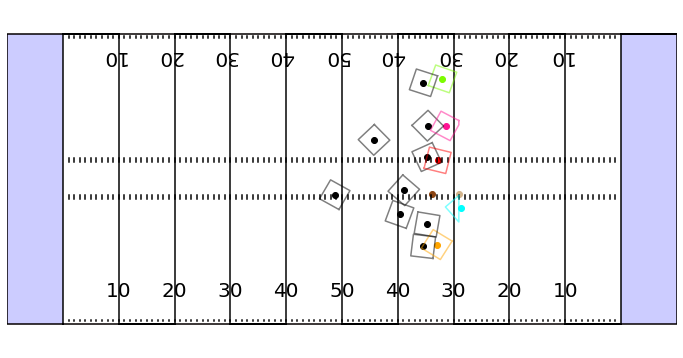

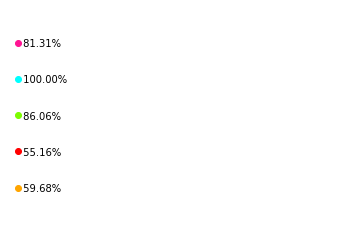

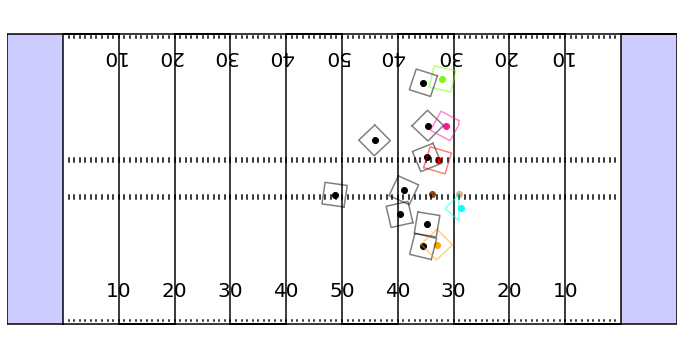

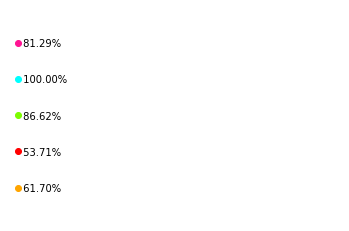

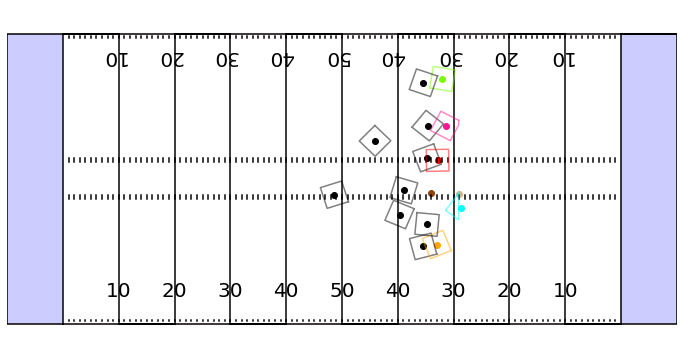

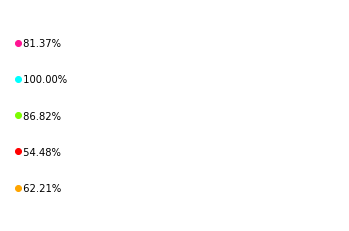

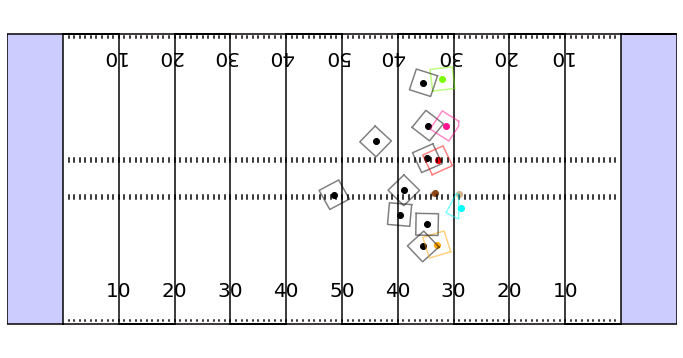

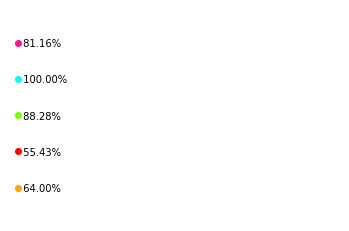

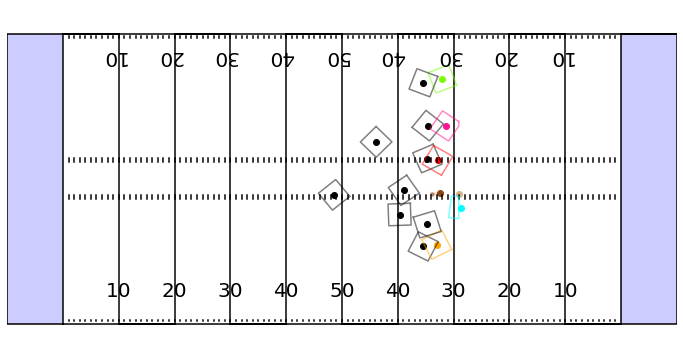

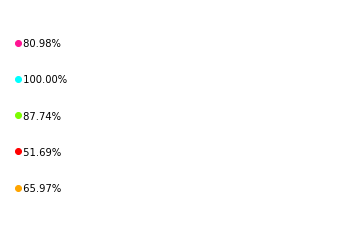

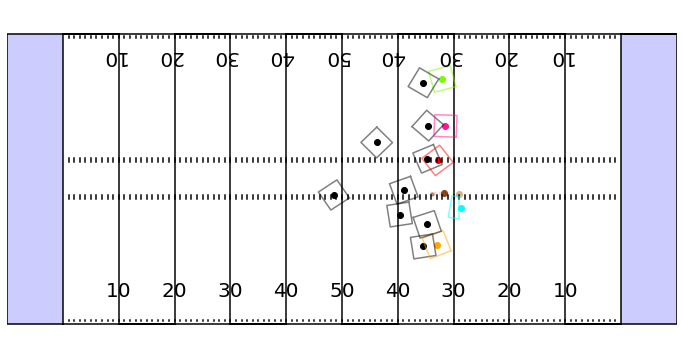

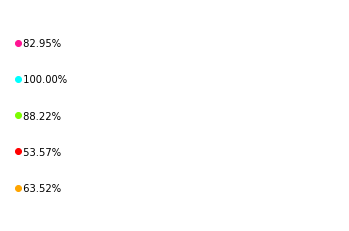

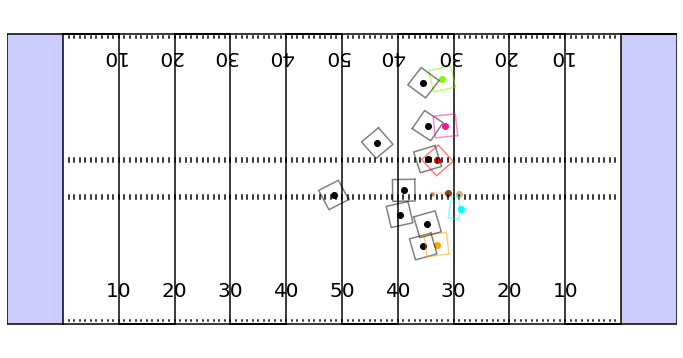

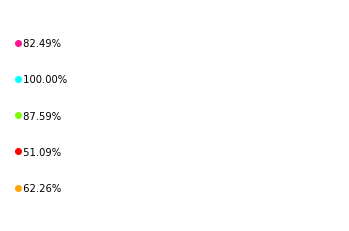

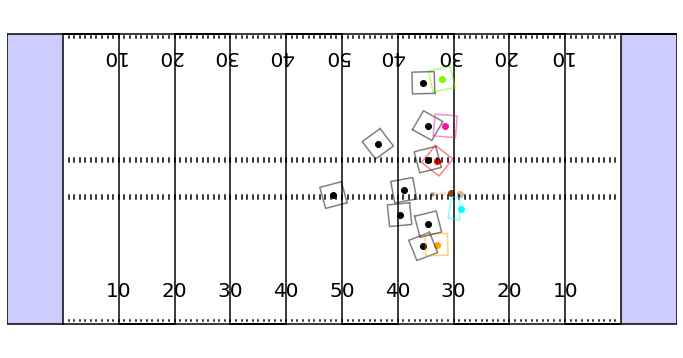

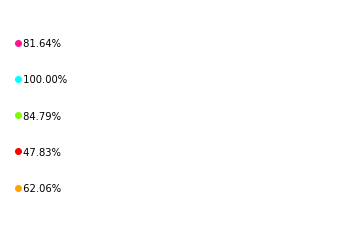

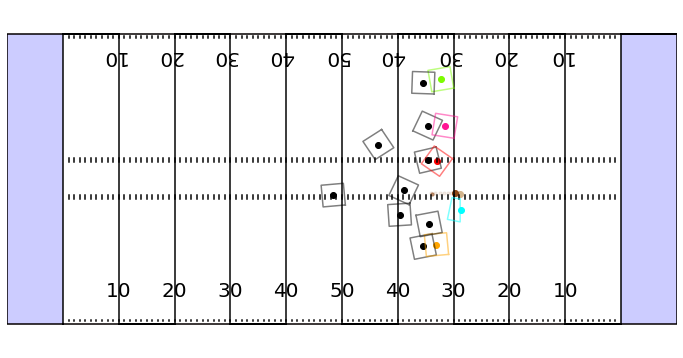

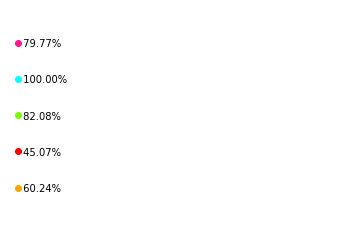

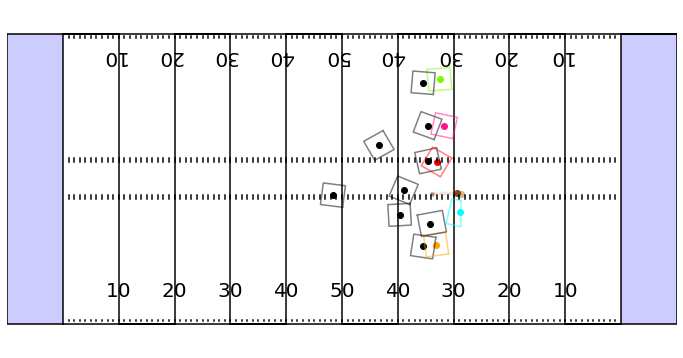

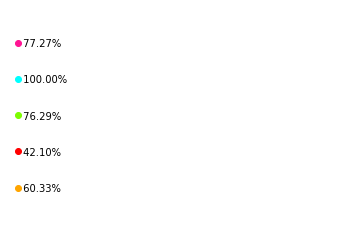

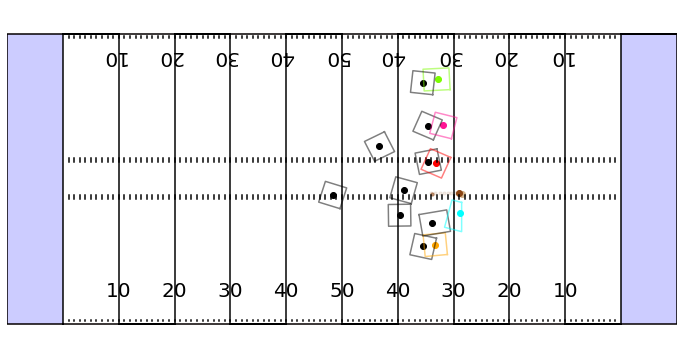

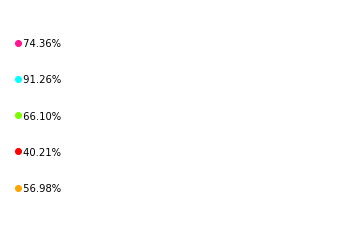

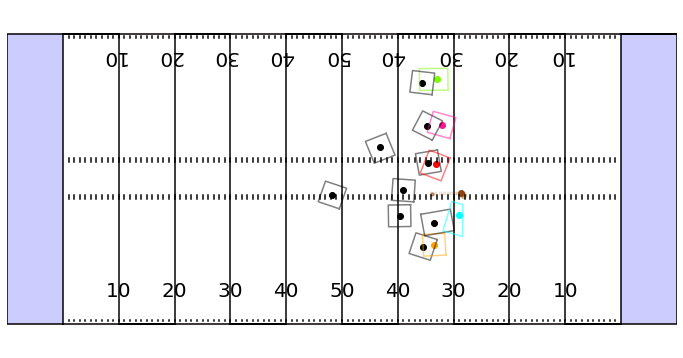

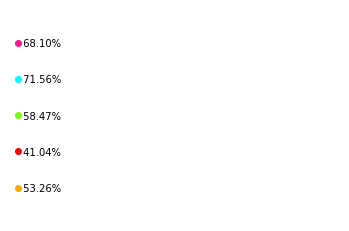

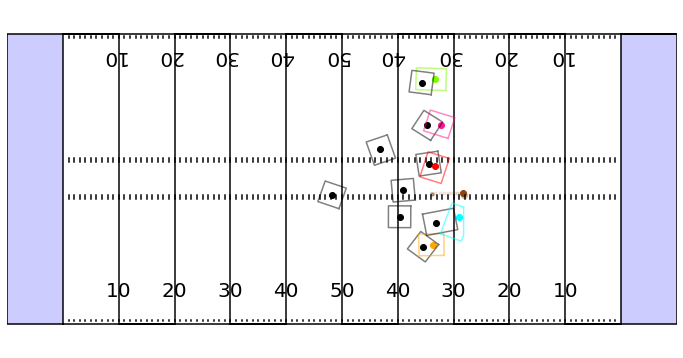

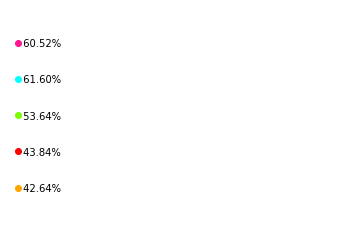

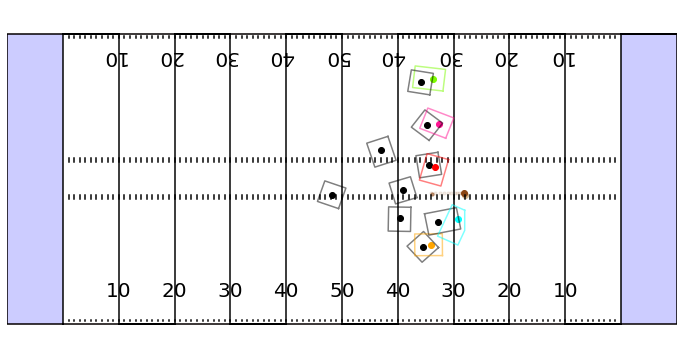

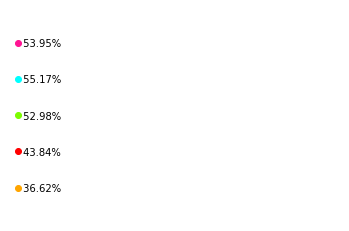

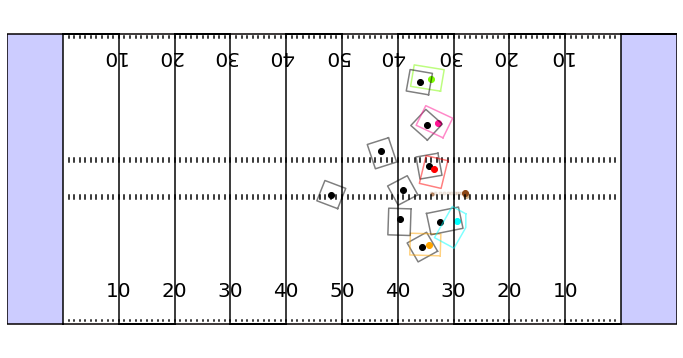

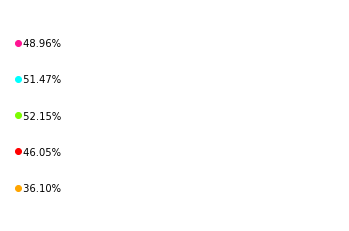

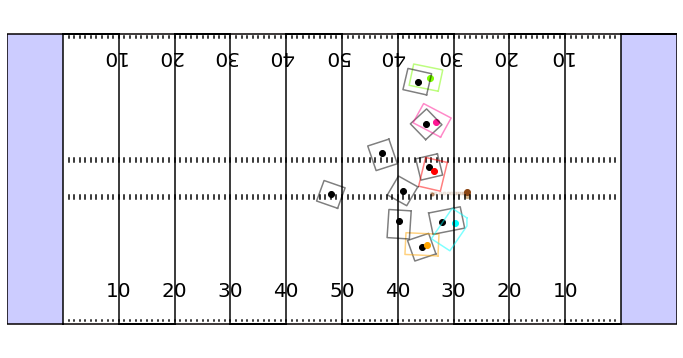

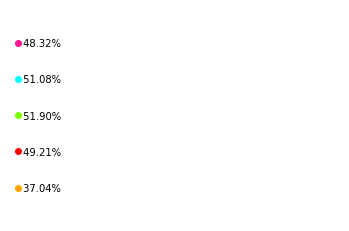

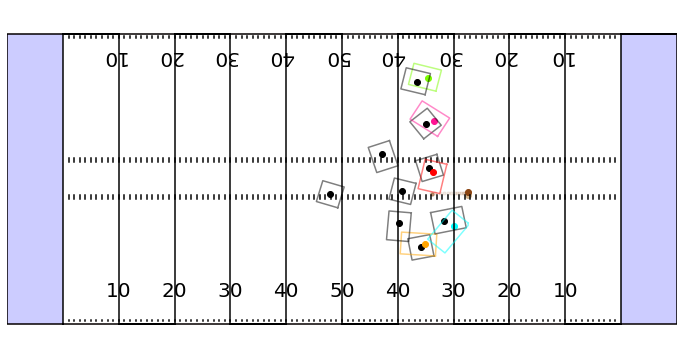

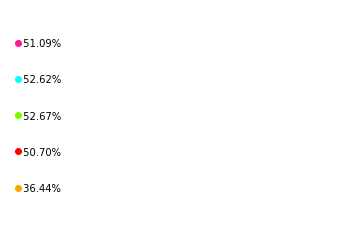

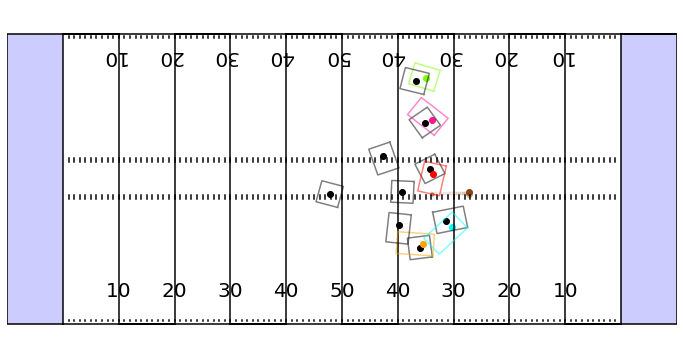

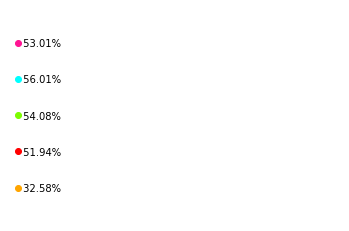

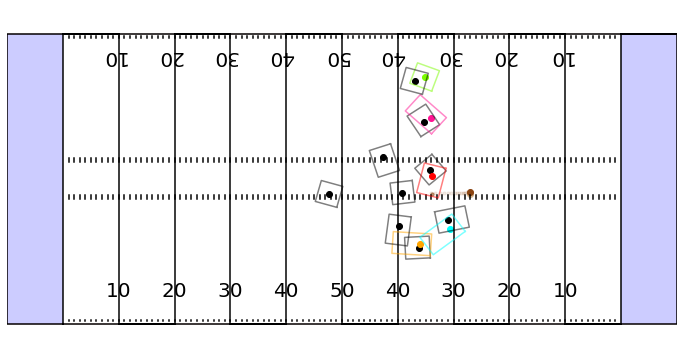

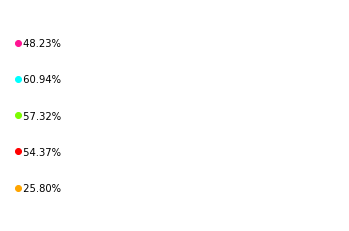

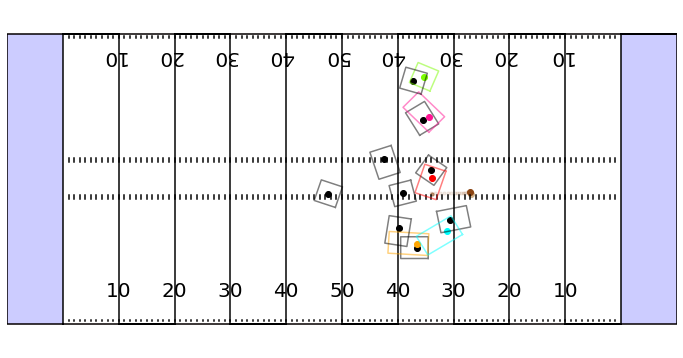

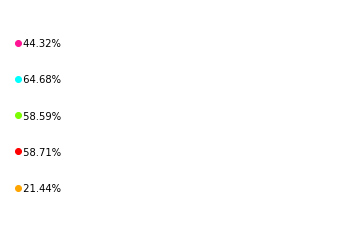

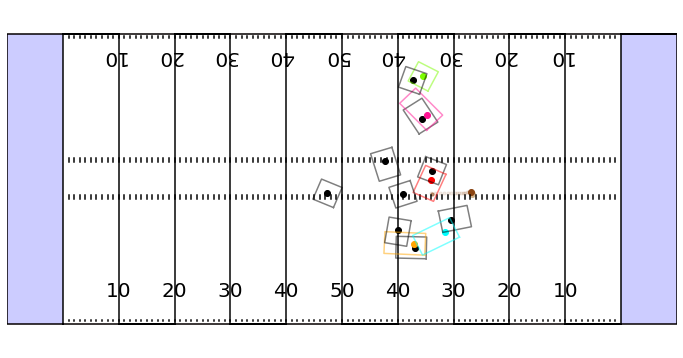

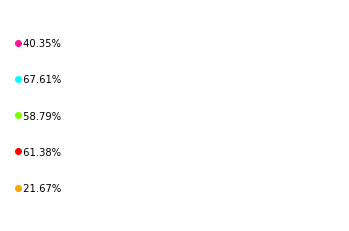

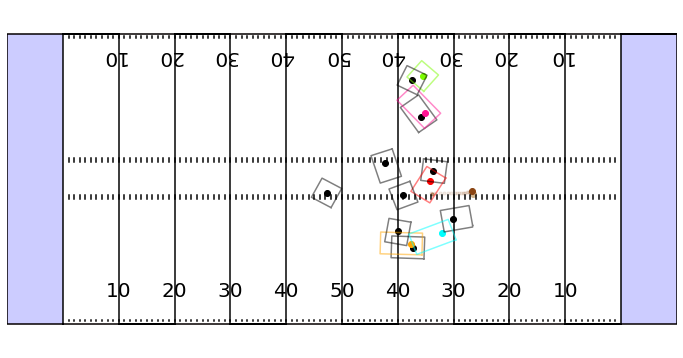

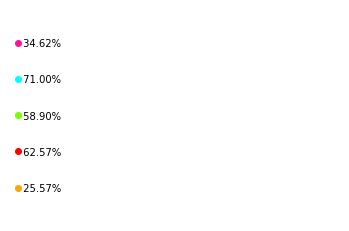

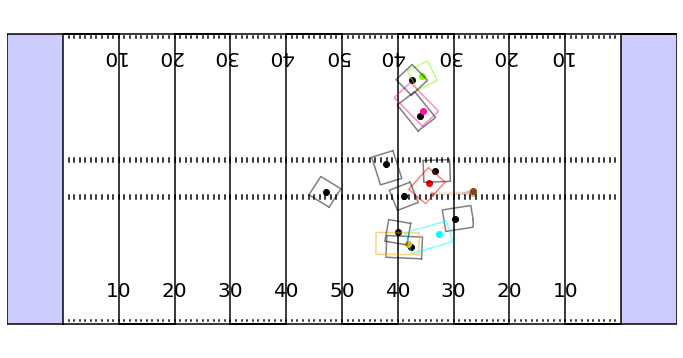

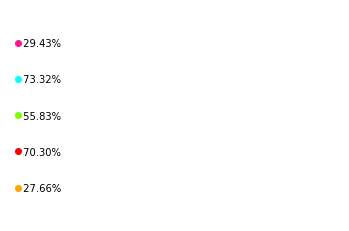

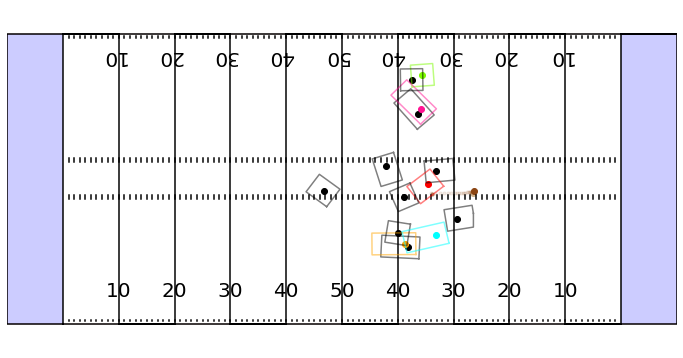

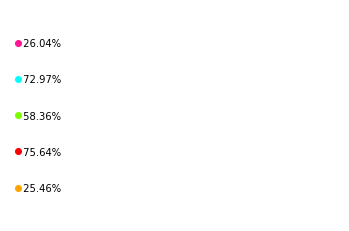

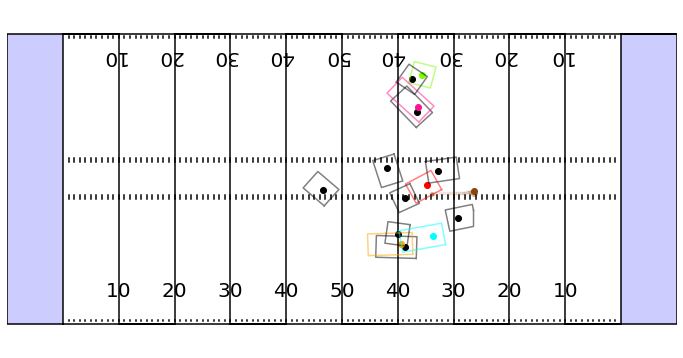

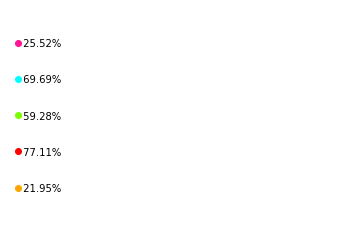

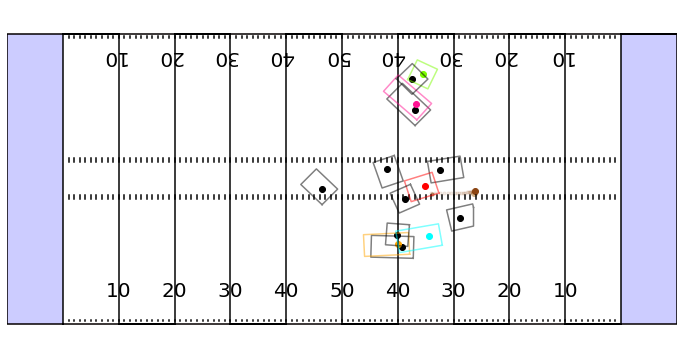

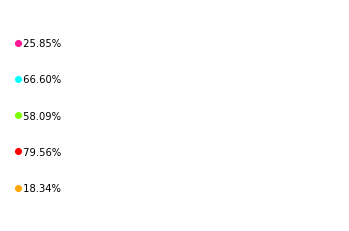

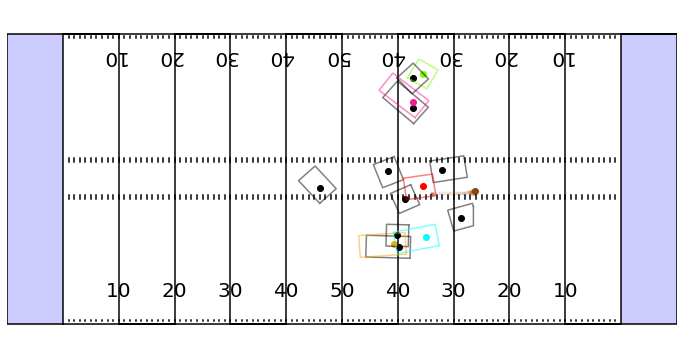

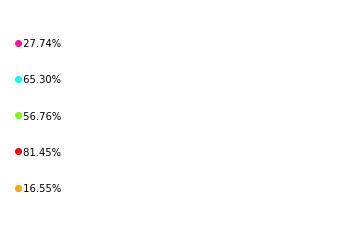

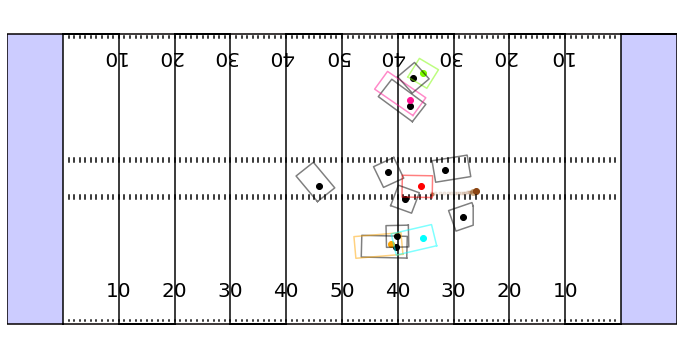

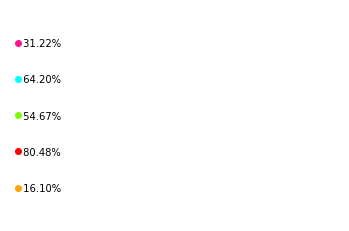

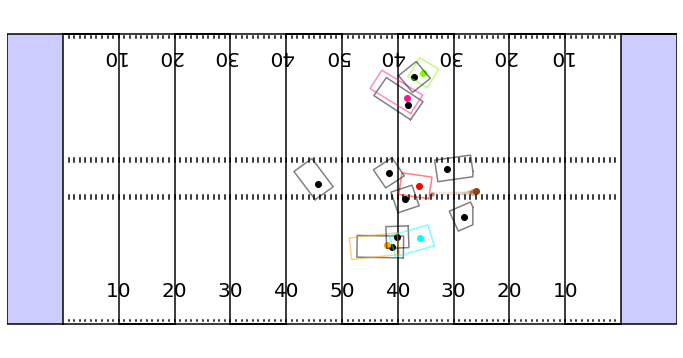

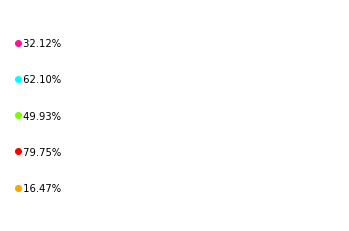

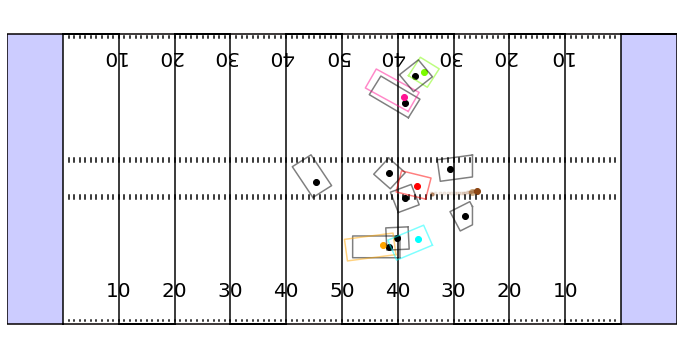

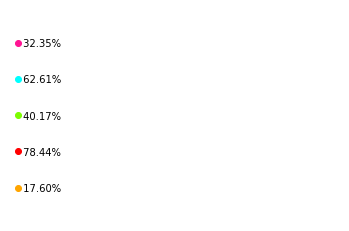

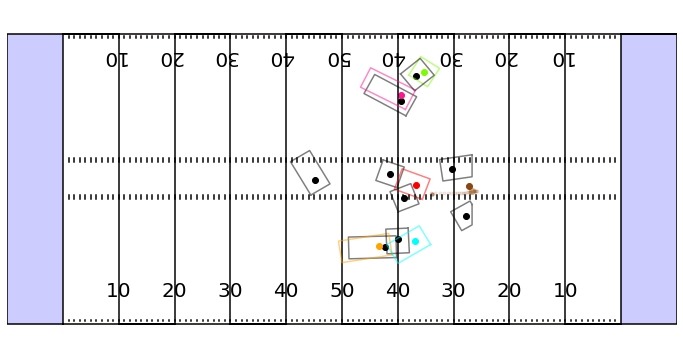

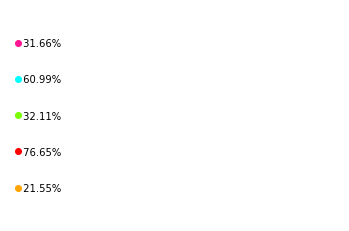

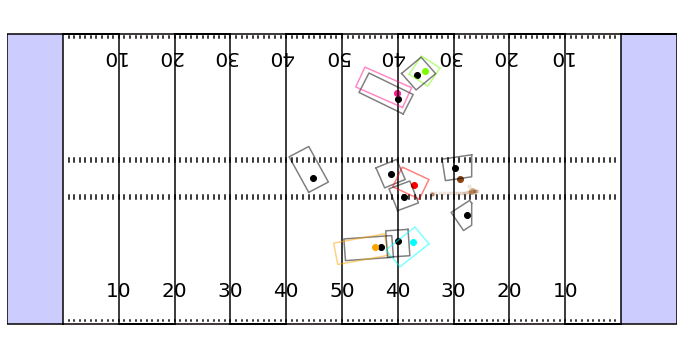

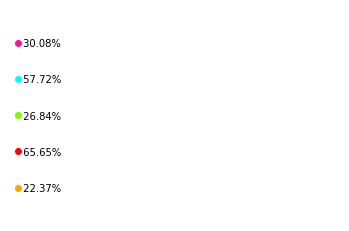

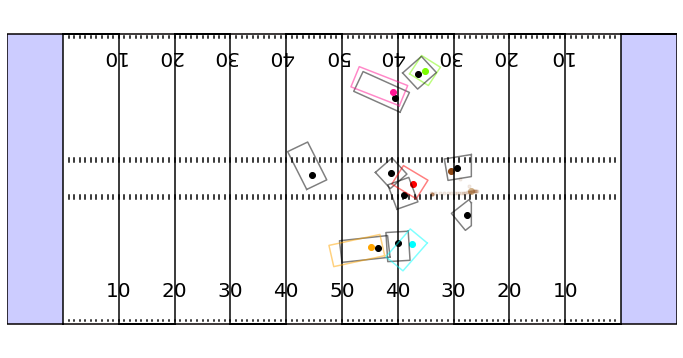

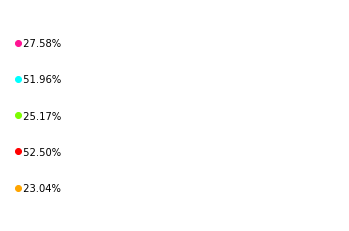

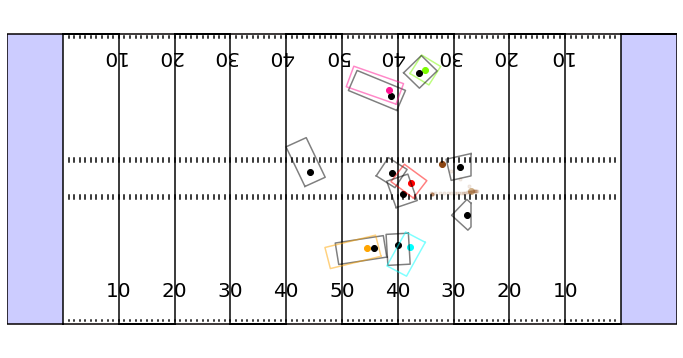

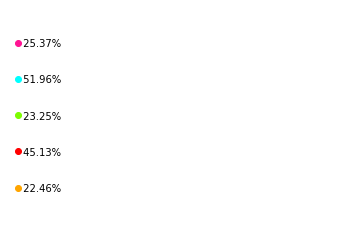

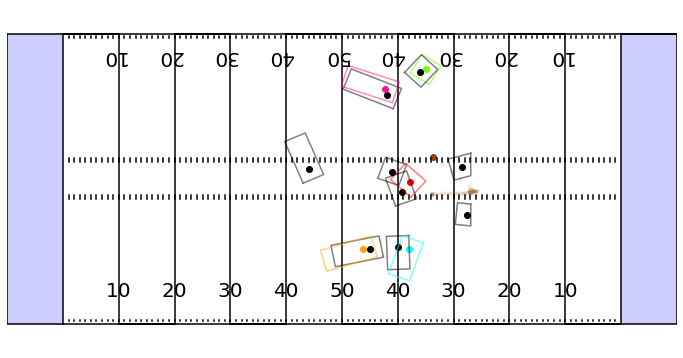

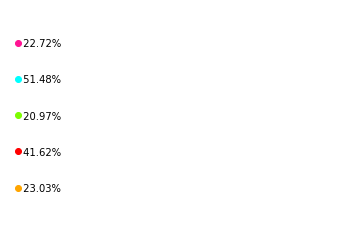

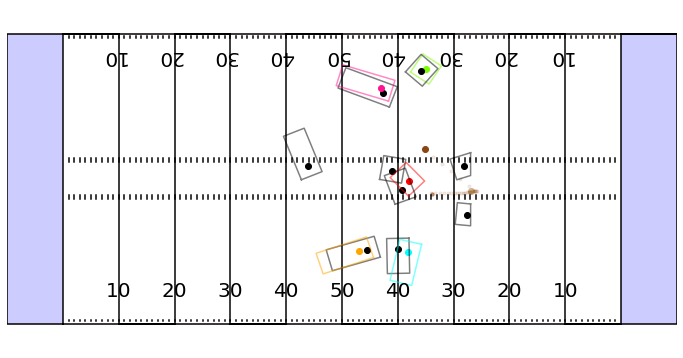

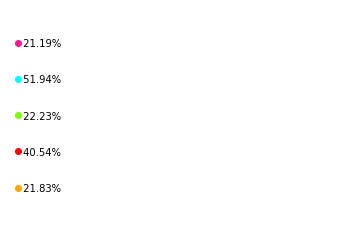

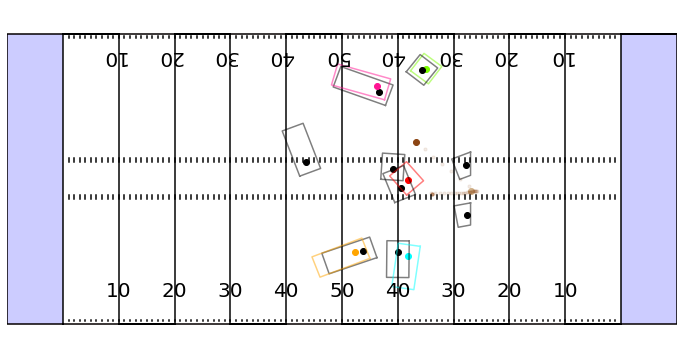

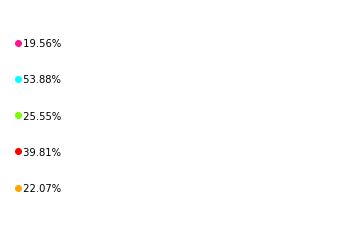

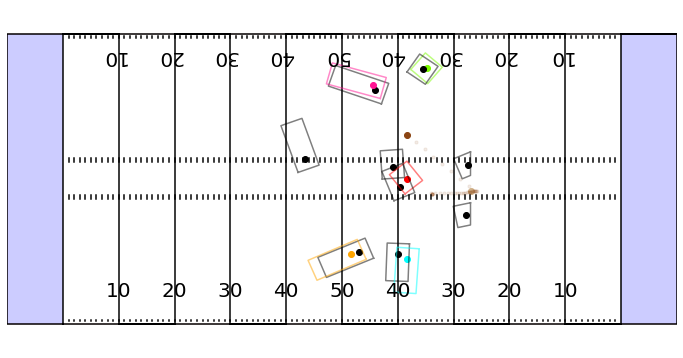

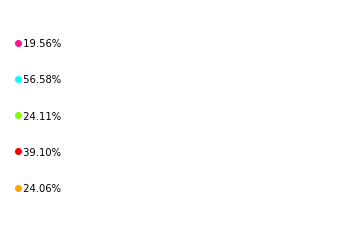

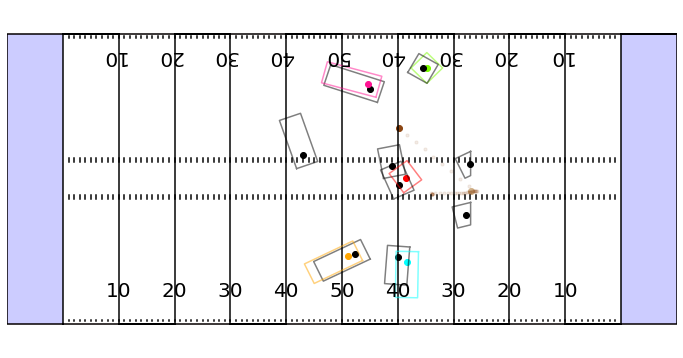

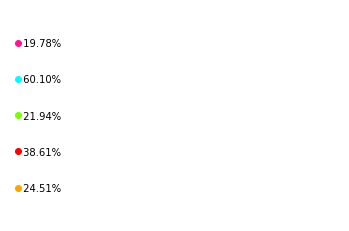

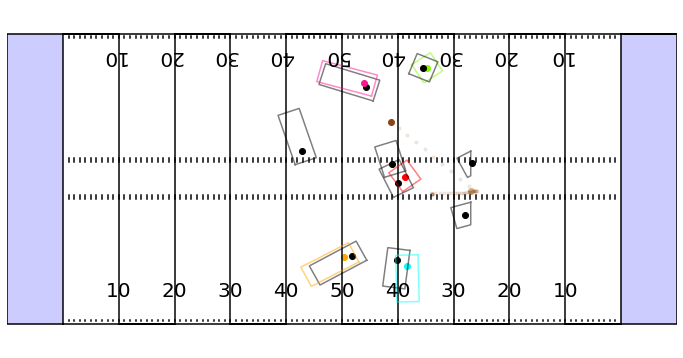

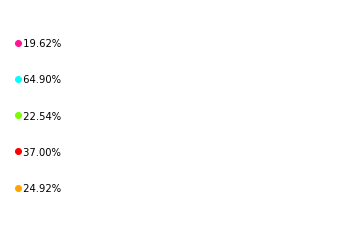

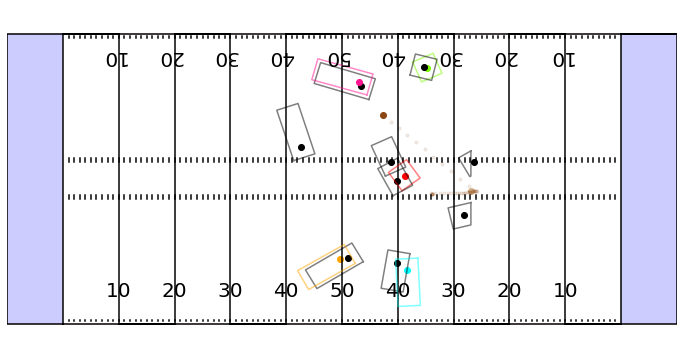

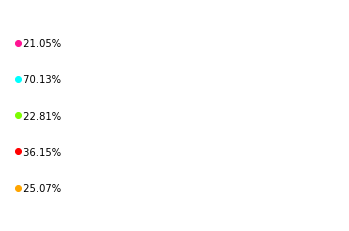

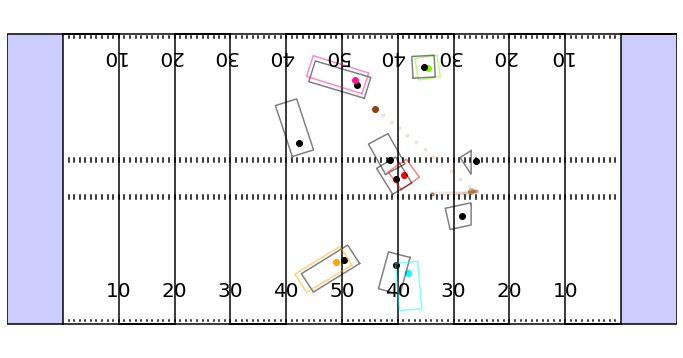

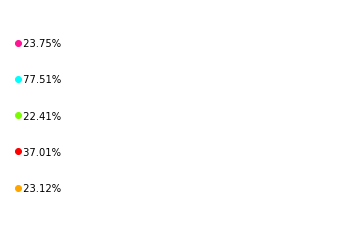

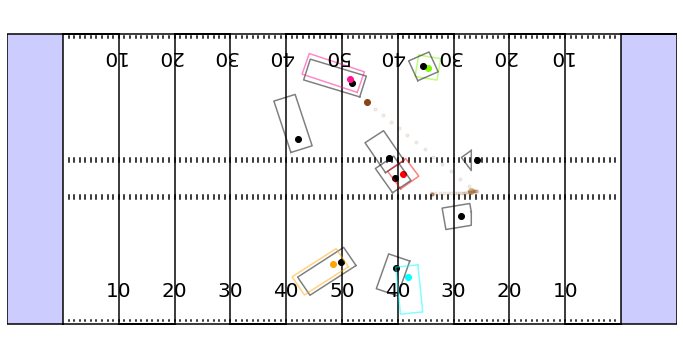

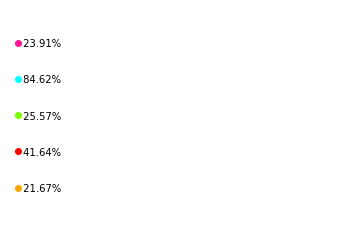

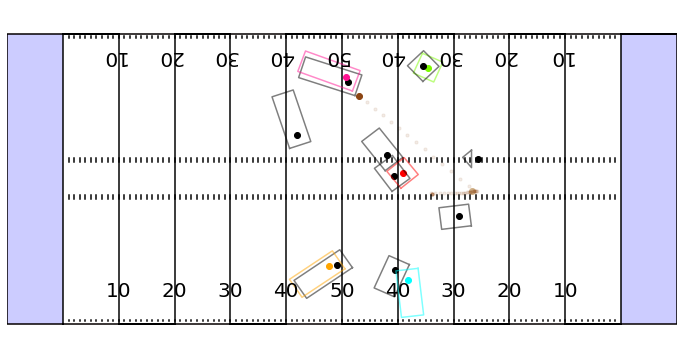

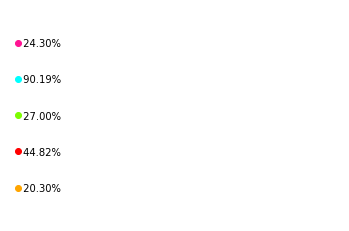

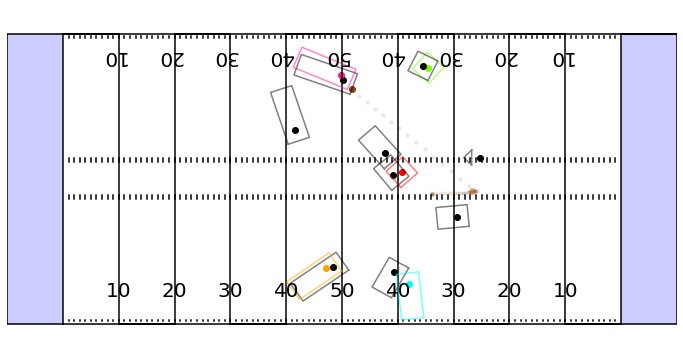

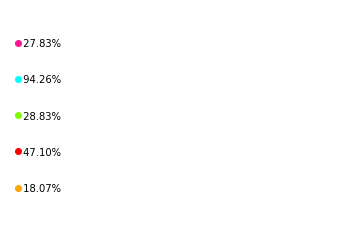

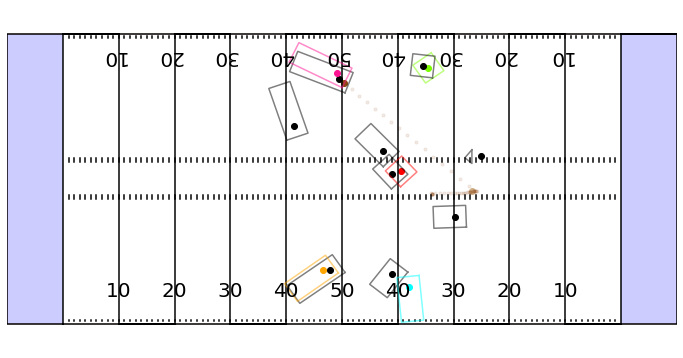

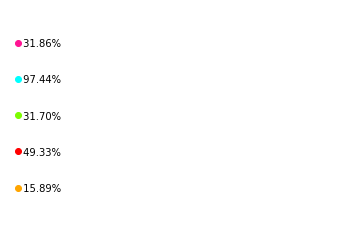

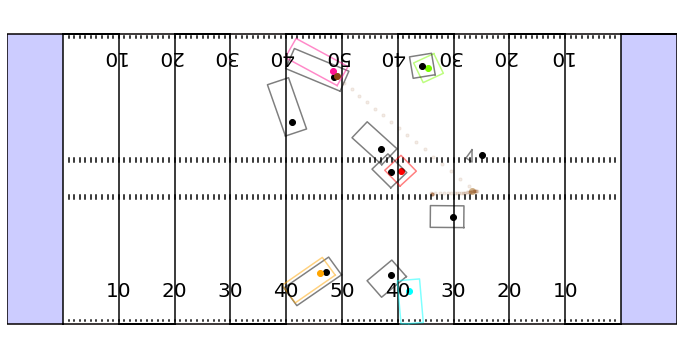

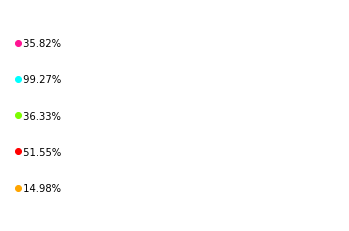

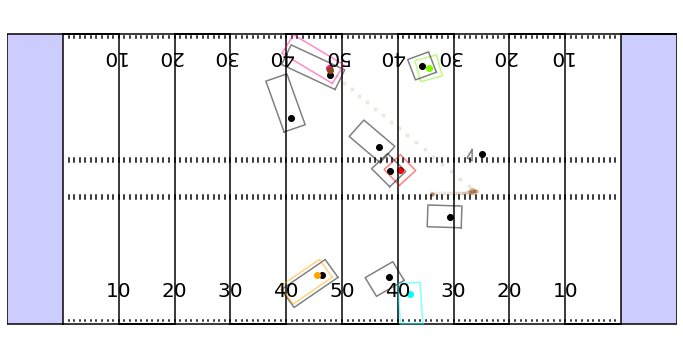

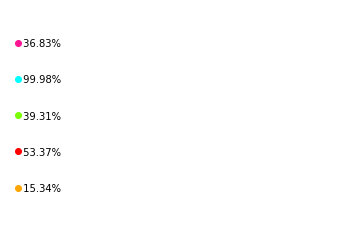

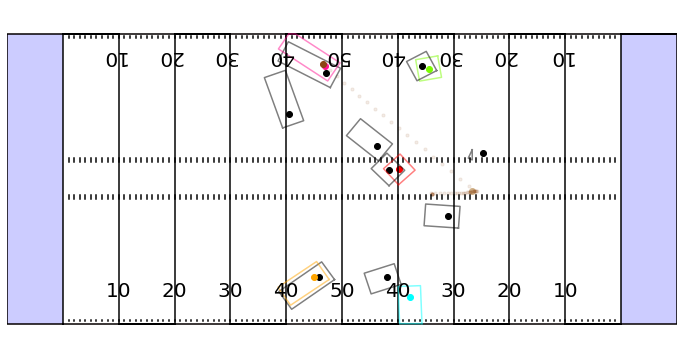

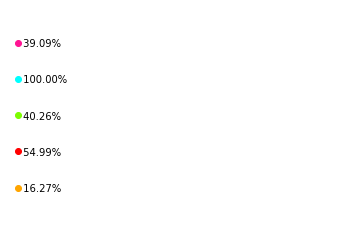

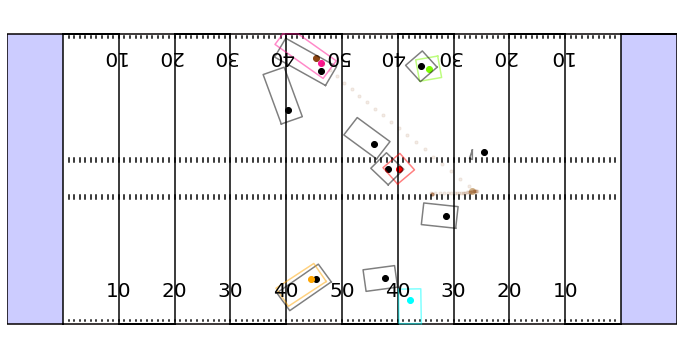

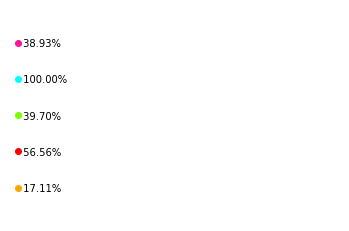

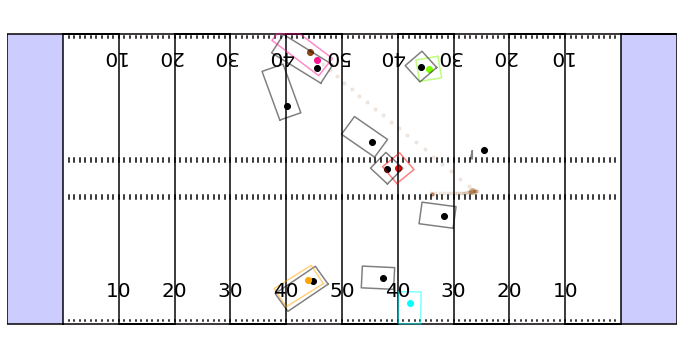

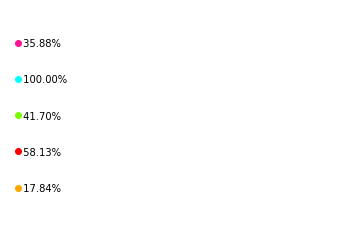

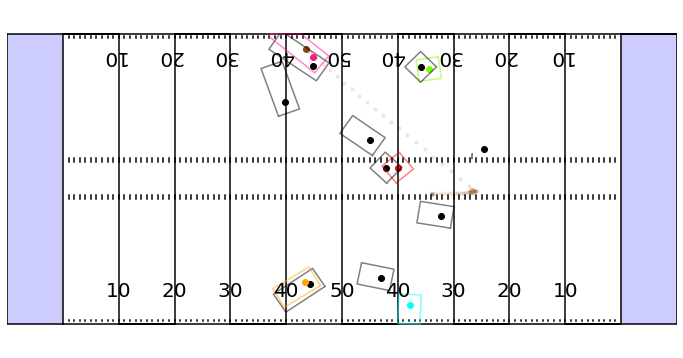

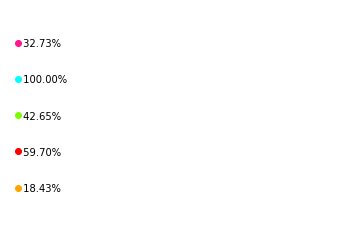

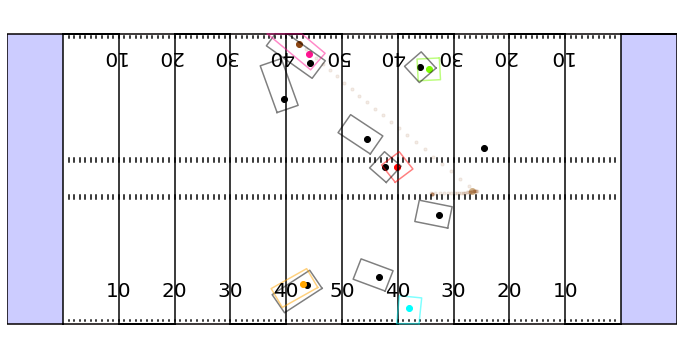

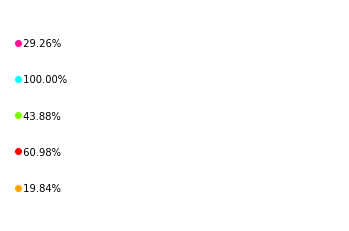

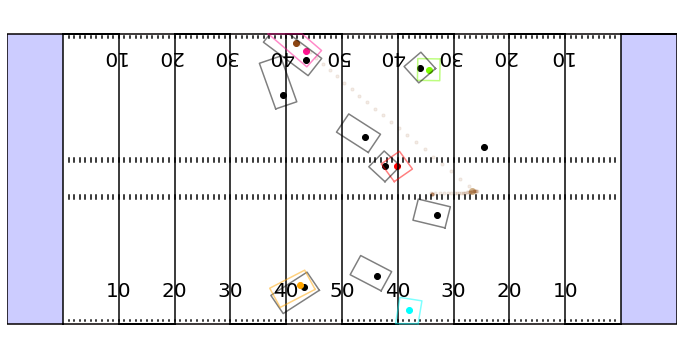

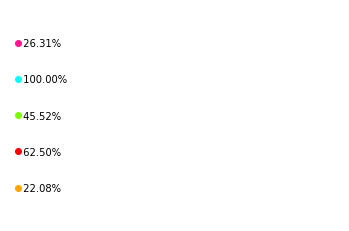

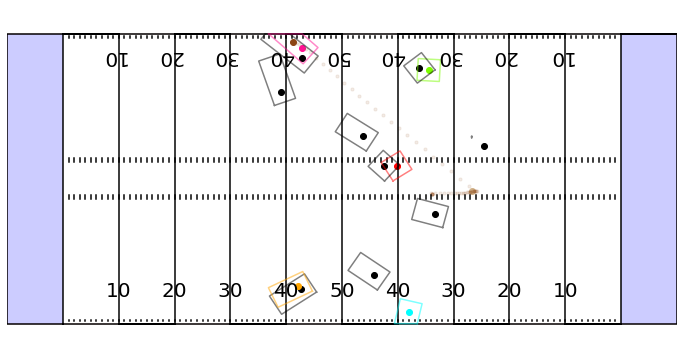

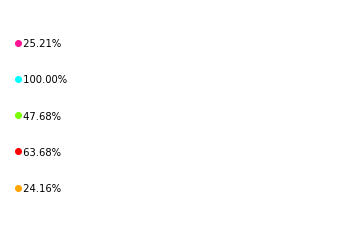

In [21]:
colors = ["orange", "red", "lawngreen", "aqua", "deeppink", ]
football = 'football'


def save_plot(name):
    fn = join(graph_fldr, f'{name}.png')
    print(f'Saving graph: {fn}')
    plt.savefig(fn,
                dpi=None,
                facecolor='w',
                edgecolor='w',
                orientation='landscape',
                format=None,
                transparent=False,
                bbox_inches=None,
                pad_inches=0.1)

def get_color(row, player_colors):
    if row['is_defense']:
        return 'black'
    
    elif row['position'] == 'QB':
        return "tan"
    
    elif row['team'] == 'football':
        return "saddlebrown"
    
    elif row['eligible_receiver']:
        try:
            return player_colors[row['nflId']]
        except KeyError:
            player_colors[row['nflId']] = colors.pop(0)
            return player_colors[row['nflId']]

def graph_openness_frames(n_frames, plot_rects, player_colors):
    colors_not_set = not player_colors
    fig, ax = create_football_field()
    receivers = {}
    current_frame = None
    captured = 0
    for index, row in play_data.iterrows():
        if current_frame is None:
            current_frame = row['frameId']
        if current_frame != row['frameId']:
            current_frame = row['frameId']
            captured += 1
        if captured >= n_frames:
            break
        color = get_color(row, player_colors)
        if row['frameId'] == n_frames:
            try:
                if plot_rects:
                    X, Y = row.polygon.exterior.coords.xy
                    ax.plot(X, Y, color=color, alpha=0.5)
            except AttributeError:
                pass
            if row['eligible_receiver']:
                receivers[color] = f'{row["openness"] * 100: 0.2f}%'
            ax.scatter(row['x'], row['y'], color=color)
#     for player_id, color in players:
#         player_data = play_data.query('nflId == @player_id and frameId <= @n_frames')
#         player_data.plot(x='x', y='y', kind='scatter', ax=ax, color=color, s=10, alpha=0.3)
    football_data = play_data.query('team == @football and frameId <= @n_frames')
    football_data.plot(x='x', y='y', kind='scatter', ax=ax, color="saddlebrown", s=10,  alpha=0.1)
#     plt.title('Game #{}: Play {}'.format(game_id, play_id))
    save_plot(f'PlayAction_{n_frames}')
    return current_frame, row['event'] == 'pass_arrived', player_colors, receivers

def plot_openness_legend(receivers, n):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylim(0, 6)
    ax.set_xlim(0.95, 2.5)
    plt.axis('off')
    y = 1
    for color, openness in receivers.items():
        ax.plot([1], [y], 'o', color=color)        
        ax.text(1.01, y - 0.1, openness)
        y += 1
    save_plot(f'Openness_{n}')


def make_gif_images():
    n = 1
    arrived = False
    player_colors = {}
    while 1:
        new_n, pass_arrived, player_colors, receivers = graph_openness_frames(n, not arrived, player_colors)
        if not arrived:
            temp_receivers = receivers.copy()
        if pass_arrived:
            arrived = True
        plot_openness_legend(temp_receivers, n)
        if new_n == n:
            break
        n = new_n

all_game_ids = data['gameId'].unique()

game_id = all_game_ids[0]
game_data = data.query('gameId == @game_id')
game_play_ids = game_data['playId'].unique()
play_id = game_play_ids[3]

graph_fldr = f'./graphs/{game_id}/{play_id}'
os.makedirs(graph_fldr, exist_ok=True)

play_data = game_data.query('gameId == @game_id and playId == @play_id')

make_gif_images()

In [22]:
out_path = join(graph_fldr, 'merged')
os.makedirs(out_path, exist_ok=True)

field_files = glob(graph_fldr + f'/Play*.png')
openn_files = glob(graph_fldr + f'/Open*.png')
field_files.sort()
openn_files.sort()
assert len(field_files) == len(openn_files)


def crop_field(img_fn, left_offset, right_offset, show=False):
    img = Image.open(img_fn)
    w, h = img.size
    
    left = max(80, left_offset)
    top = 50
    right = w - max(80, right_offset)
    bottom = h - 50

    crp_img = img.crop((left, top, right, bottom))
    
    if show:
        imshow(np.asarray(crp_img))
    
    return crp_img

def crop_openness(img_fn, show=False):
    img = Image.open(img_fn)
    w, h = img.size

    left = 50
    top = 10
    right = w - 270
    bottom = h

    crp_img = img.crop((left, top, right, bottom))
    
    if show:
        imshow(np.asarray(crp_img))
    
    return crp_img

def merge_images(field_img, openn_img, fn=None):
    f_w, f_h = field_img.size
    o_w, o_h = openn_img.size
    
    new_image = Image.new('RGB',(f_w + o_w, f_h), (255,255,255))
    new_image.paste(field_img, (0,0))
    new_image.paste(openn_img, (f_w, 45))
    
    if fn is not None:
        new_image.save(fn, "PNG")
    else:
        return new_image

def crop_and_merge_all(left_offset, right_offset):
    for f_fn, o_fn in zip(field_files, openn_files):
        f_frame = basename(f_fn).split('_')[1].replace('.png', '')
        o_frame = basename(o_fn).split('_')[1].replace('.png', '')

        assert f_frame == o_frame, f'{f_fn}\n{o_fn}\nIncompatable files.'

        field_img = crop_field(f_fn, left_offset, right_offset)
        openn_img = crop_openness(o_fn, show=False)
        merge_images(field_img, openn_img, join(out_path, f'Merged_{f_frame}.png'))

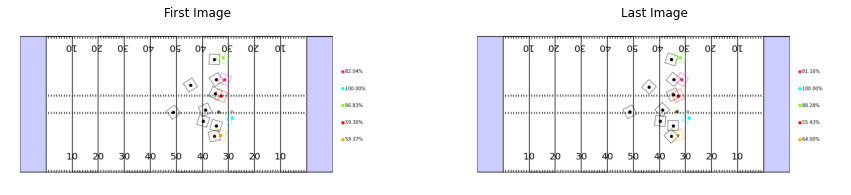

In [23]:
def find_cropping(f1_fn, o1_fn, fl_fn, ol_fn):
    f1_img = crop_field(f1_fn, left_offset, right_offset)
    o1_img = crop_openness(o1_fn)
    first_img = merge_images(f1_img, o1_img)
    
    fl_img = crop_field(fl_fn, left_offset, right_offset)
    ol_img = crop_openness(ol_fn)
    last_img = merge_images(fl_img, ol_img)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    ax1.imshow(first_img)
    ax1.set_title('First Image')
    ax1.set_axis_off()
    ax2.imshow(last_img)
    ax2.set_title('Last Image')
    ax2.set_axis_off()

# Adjust left and right offset until the output image looks good
left_offset = 0
right_offset = 0
find_cropping(field_files[0], openn_files[0], field_files[-1], openn_files[-1])

In [24]:
crop_and_merge_all(left_offset, right_offset)